# INTRODUCTION
In this notebook, we'll try to run the TOD models on the samples provided from the ISRO. We'll try some preprocessing and then run some models on them to see the model can detect something. In hindsight, they shouldn't because they aren't trained for this. But a fun experiment nonetheless and also to measure the work that's cut out for us.

## Preprocessing
We'll first start by inspecting the images and doing some basic pre-processing to see if we can transform the image to a better version

In [2]:
import numpy as np
import torch 
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage as ndi
from skimage import exposure, img_as_ubyte
from skimage.filters import laplace


In [18]:
#Import the tiff images from the images folder
def import_tiff_images(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.tiff') or filename.endswith('.tif'):
            img_path = os.path.join(folder_path, filename)
            img = np.array(Image.open(img_path))
            print(img.shape)
            images.append(img)
            break
    return np.array(images)

(508, 527)


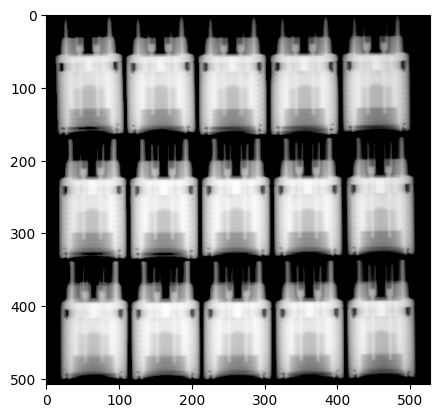

In [20]:
images = import_tiff_images('/Users/apple/Desktop/IISC/M.Tech Project/Code/Images')
plt.imshow(images[0], cmap='gray')

As you can see the images contains 3 rows, with 5 GTMS per row. There is a lot unneed space in the image that not really needed for our need. We'd ideally like to crop each of these GTMS from the each of the rows and pre-process on them. For the time-being I've manually cut out the needed part. Now the images are unprocessed and looking a bit too bright and lacking contrast to the point whrerin we can't even see the voids. We'll try some image pre-processing techniques to see we make the voids pop-out a bit more. 

In [4]:
def read_gray(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    # If image has multiple channels, convert to grayscale using OpenCV
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Convert to uint8 if needed
    if img.dtype != np.uint8:
        # Normalize into 0..255
        imin, imax = img.min(), img.max()
        if imax == imin:
            img = np.zeros_like(img, dtype=np.uint8)
        else:
            img = ((img - imin) / (imax - imin) * 255.0).astype(np.uint8)
    return img


def save_img(path, img):
    """Save uint8 grayscale image."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    cv2.imwrite(path, img)


# 1. Histogram Equalization (global)
def hist_equalization(img):
    """
    Global histogram equalization using OpenCV.
    img: uint8 grayscale
    """
    return cv2.equalizeHist(img)


# 2. CLAHE (Contrast Limited Adaptive Histogram Equalization)
def clahe(img, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe_obj = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe_obj.apply(img)


# 3. Gamma Correction
def gamma_correction(img, gamma=1.5):
    """
    img: uint8 grayscale
    gamma: >1 darkens image, <1 brightens image
    """
    inv_gamma = 1.0 / gamma
    # build lookup table
    table = (np.arange(256) / 255.0) ** inv_gamma * 255.0
    table = np.clip(table, 0, 255).astype('uint8')
    return cv2.LUT(img, table)


# 4. Unsharp Masking (edge enhancement)
def unsharp_mask(img, sigma=1.0, amount=1.2, threshold=0):
    """
    Classic unsharp mask:
      blurred = gaussian(img, sigma)
      mask = img - blurred
      result = img + amount * mask
    amount: strength of sharpening
    threshold: minimal brightness change to sharpen (0 = no threshold)
    """
    img_f = img.astype(np.float32)
    blurred = cv2.GaussianBlur(img_f, (0, 0), sigmaX=sigma, sigmaY=sigma)
    mask = img_f - blurred
    if threshold > 0:
        low_contrast_mask = np.absolute(mask) < threshold
        mask[low_contrast_mask] = 0
    sharpened = img_f + amount * mask
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)
    return sharpened


# 5. High-Pass Filter (background removal)
def high_pass_filter(img, sigma=10):
    """
    Remove low-frequency background by subtracting a Gaussian-blurred version.
    Useful to reveal small translucent defects.
    """
    img_f = img.astype(np.float32)
    low = cv2.GaussianBlur(img_f, (0, 0), sigmaX=sigma, sigmaY=sigma)
    hp = img_f - low
    # re-normalize to 0..255 for visualization
    hp_norm = 255 * (hp - hp.min()) / (hp.max() - hp.min() + 1e-9)
    return hp_norm.astype(np.uint8)


# 6. Adaptive thresholding (local binarization)
def adaptive_threshold(img, block_size=51, C=5):
    """
    Detect candidate voids by local thresholding.
    block_size must be odd.
    """
    # OpenCV adaptiveThreshold requires 8-bit single-channel
    thr = cv2.adaptiveThreshold(img, 255,
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY_INV,
                                block_size, C)
    return thr


# 7. Top-hat and Black-hat morphological filtering
def top_black_hat(img, kernel_size=15):
    """
    Returns (top_hat, black_hat).
    - top_hat (white top-hat) enhances small bright features on a dark background
    - black_hat enhances small dark features on a bright background
    """
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    top_hat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k)
    black_hat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, k)
    return top_hat, black_hat


# 8. Multi-scale Laplacian of Gaussian (LoG) response
def multiscale_log(img, sigmas=(1.0, 2.0, 3.0, 4.0)):
    """
    Compute multi-scale LoG (absolute) and sum responses.
    Returns a normalized uint8 image where high values indicate strong LoG responses.
    """
    img_f = img.astype(np.float32) / 255.0
    responses = []
    for s in sigmas:
        # gaussian_laplace returns negative on bright spots; take absolute
        r = -ndi.gaussian_laplace(img_f, sigma=s)
        responses.append(np.abs(r))
    resp = np.sum(responses, axis=0)
    # normalize
    resp_norm = 255 * (resp - resp.min()) / (resp.max() - resp.min() + 1e-9)
    return resp_norm.astype(np.uint8)


# Utility: show several images in a grid (matplotlib)
def show_grid(titles, images, figsize=(12, 8)):
    n = len(images)
    cols = min(3, n)
    rows = (n + cols - 1) // cols
    plt.figure(figsize=figsize)
    for i, (t, im) in enumerate(zip(titles, images), 1):
        plt.subplot(rows, cols, i)
        plt.imshow(im, cmap='gray', vmin=0, vmax=255)
        plt.title(t)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


def process_all(input_path, outdir, params=None, show=False):
    if params is None:
        params = {}
    img = np.array(Image.open(input_path))

    # 1) Histogram equalization
    he = hist_equalization(img)
    save_img(os.path.join(outdir, 'hist_equalized.png'), he)

    # 2) CLAHE
    cl = clahe(img, clip_limit=params.get('clahe_clip', 2.0),
               tile_grid_size=params.get('clahe_tile', (8, 8)))
    save_img(os.path.join(outdir, 'clahe.png'), cl)

    # 3) Gamma correction
    gamma = params.get('gamma', 1.6)
    g = gamma_correction(img, gamma=gamma)
    save_img(os.path.join(outdir, f'gamma_{gamma:.2f}.png'), g)

    # 4) Unsharp mask
    us = unsharp_mask(img, sigma=params.get('us_sigma', 1.0),
                      amount=params.get('us_amount', 1.2),
                      threshold=params.get('us_threshold', 0))
    save_img(os.path.join(outdir, 'unsharp.png'), us)

    # 5) High-pass
    hp = high_pass_filter(img, sigma=params.get('hp_sigma', 20))
    save_img(os.path.join(outdir, 'highpass.png'), hp)

    # 6) Adaptive threshold
    at = adaptive_threshold(img, block_size=params.get('at_block', 51),
                            C=params.get('at_C', 5))
    save_img(os.path.join(outdir, 'adaptive_threshold.png'), at)

    # 7) Top-hat and black-hat
    th, bh = top_black_hat(img, kernel_size=params.get('morph_kernel', 25))
    save_img(os.path.join(outdir, 'tophat.png'), th)
    save_img(os.path.join(outdir, 'blackhat.png'), bh)

    # 8) Multi-scale LoG
    sigs = params.get('log_sigmas', (1.0, 2.0, 3.0, 4.0))
    log = multiscale_log(img, sigmas=sigs)
    save_img(os.path.join(outdir, 'multiscale_log.png'), log)

    print("Saved enhanced images to:", outdir)

    if show:
        titles = ['Original', 'CLAHE', 'Gamma', 'Unsharp', 'High-pass', 'Top-hat', 'Black-hat', 'Multi-scale LoG', 'Adaptive Threshold']
        imgs = [img, cl, g, us, hp, th, bh, log, at]
        show_grid(titles, imgs)

Saved enhanced images to: /Users/apple/Desktop/IISC/M.Tech Project/Code/Images/Enhancement_images


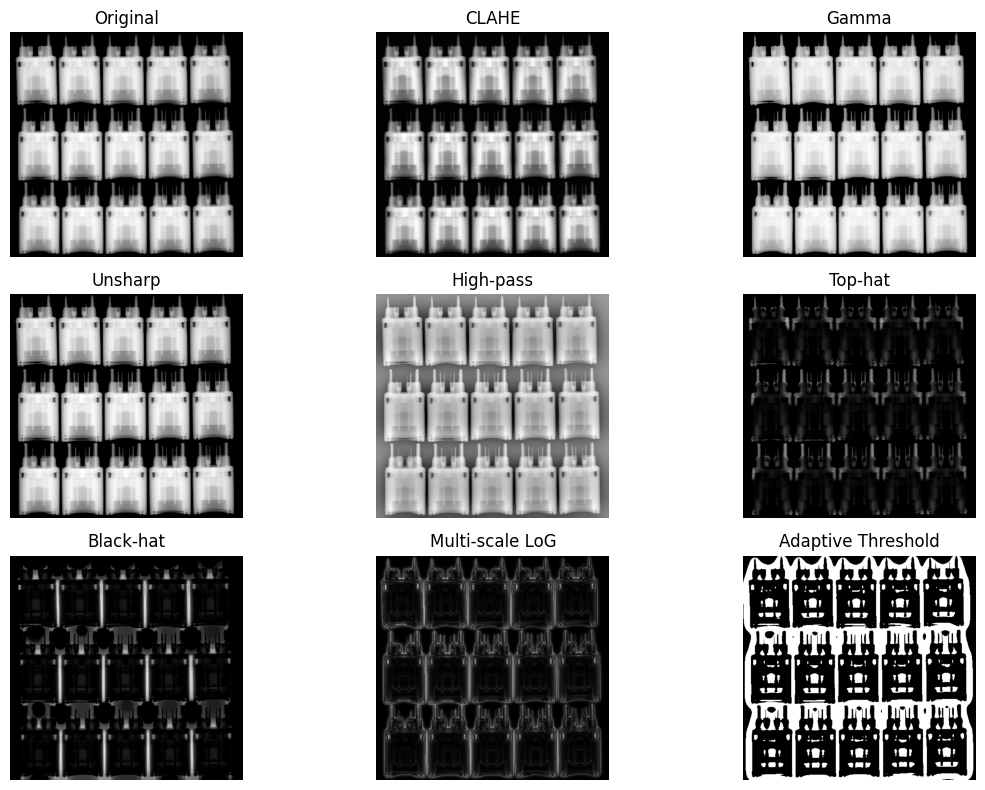

In [ ]:
output_dir = '/Users/apple/Desktop/IISC/M.Tech Project/Code/Images/Enhancement_images_A'
input_img_path = '/Users/apple/Desktop/IISC/M.Tech Project/Code/Images/Batch no; 2023-13-11---416 to 430-A shot.tiff'
os.makedirs(output_dir, exist_ok=True)
params = {
    'clahe_clip': 2.0,
    'clahe_tile': (8, 8),
    'gamma': 1.6,
    'us_sigma': 1.0,
    'us_amount': 1.2,
    'us_threshold': 0,
    'hp_sigma': 20,
    'at_block': 51,
    'at_C': 5,
    'morph_kernel': 25,
    'log_sigmas': (1.0, 2.0, 3.0, 4.0),
}
process_all(input_img_path, output_dir, params=params, show=True)

Saved enhanced images to: /Users/apple/Desktop/IISC/M.Tech Project/Code/Images/Enhancement-images_B


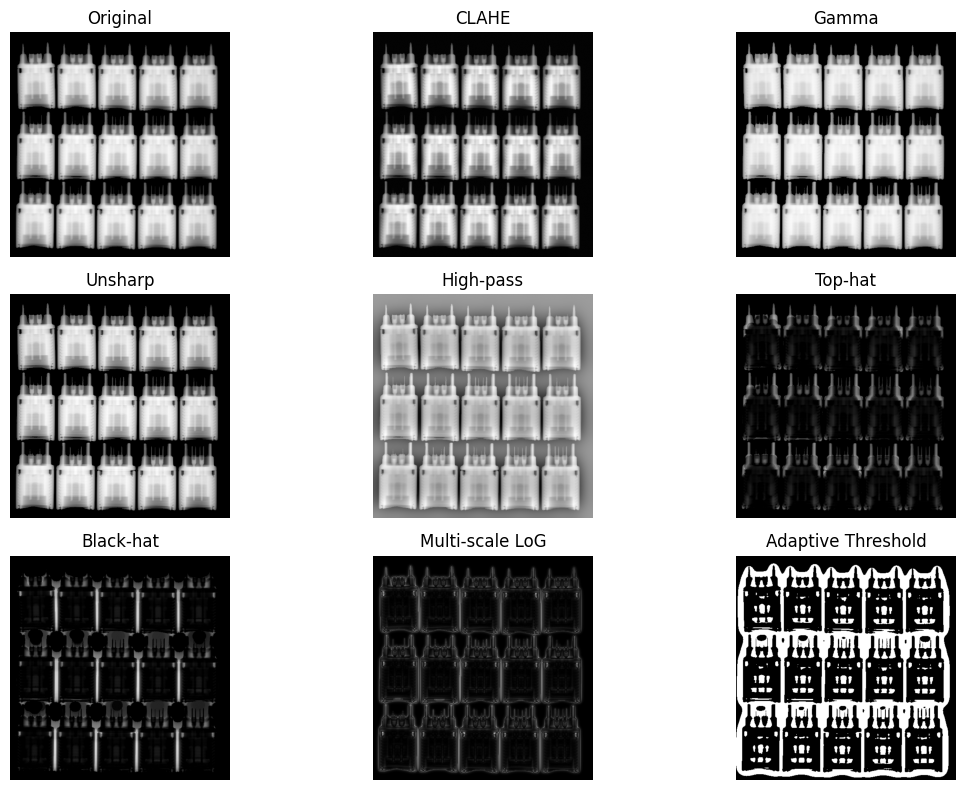

In [ ]:
output_dir = '/Users/apple/Desktop/IISC/M.Tech Project/Code/Images/Enhancement_images_B'
input_img_path = '/Users/apple/Desktop/IISC/M.Tech Project/Code/Images/Batch no; 2023-13-11---416 to 430-B shot.tiff'
os.makedirs(output_dir, exist_ok=True)
params = {
    'clahe_clip': 2.0,
    'clahe_tile': (8, 8),
    'gamma': 1.6,
    'us_sigma': 1.0,
    'us_amount': 1.2,
    'us_threshold': 0,
    'hp_sigma': 20,
    'at_block': 51,
    'at_C': 5,
    'morph_kernel': 25,
    'log_sigmas': (1.0, 2.0, 3.0, 4.0),
}
process_all(input_img_path, output_dir, params=params, show=True)

Looks like CLAHE and Histogram equalization works the best. Let's try stacking a few other transforms on top of the CLAHE output to see if we can improve the contrast a bit more

In [30]:
img = np.array(Image.open('/Users/apple/Desktop/IISC/M.Tech Project/Code/Images/Enhancement-images_B/hist_equalized.png'))

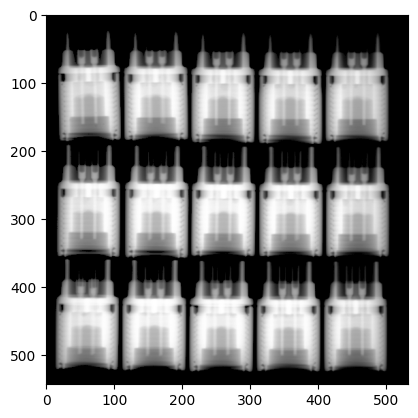

In [31]:
def clahe_then_gamma(img_clahe, gamma=1.8):
    # img_clahe: uint8 result from CLAHE
    inv_gamma = 1.0 / gamma
    table = (np.arange(256) / 255.0) ** inv_gamma * 255.0
    table = np.clip(table, 0, 255).astype('uint8')
    return cv2.LUT(img_clahe, table)
img_clahe_gamma = clahe_then_gamma(img, gamma=1.8)
plt.imshow(img_clahe_gamma, cmap='gray')
save_img('/Users/apple/Desktop/IISC/M.Tech Project/Code/Images/CLAHE_Enhancements/clahe_gamma_1.8.png', img_clahe_gamma)

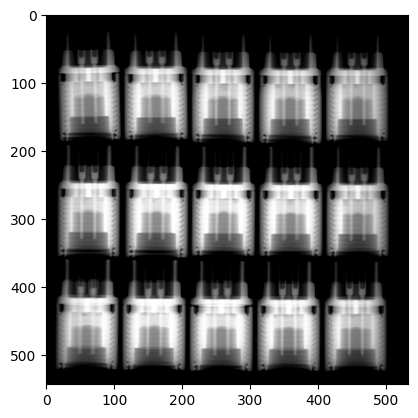

In [32]:
def clahe_then_unsharp(img_clahe, sigma=1.0, amount=1.2, threshold=0):
    img_f = img_clahe.astype(np.float32)
    blurred = cv2.GaussianBlur(img_f, (0,0), sigmaX=sigma)
    mask = img_f - blurred
    if threshold > 0:
        mask[np.abs(mask) < threshold] = 0
    out = img_f + amount * mask
    out = np.clip(out, 0, 255).astype(np.uint8)
    return out
img_clahe_unsharp = clahe_then_unsharp(img, sigma=1.0, amount=1.2, threshold=0)
plt.imshow(img_clahe_unsharp, cmap='gray')
save_img('/Users/apple/Desktop/IISC/M.Tech Project/Code/Images/CLAHE_Enhancements/clahe_unsharp.png', img_clahe_unsharp)

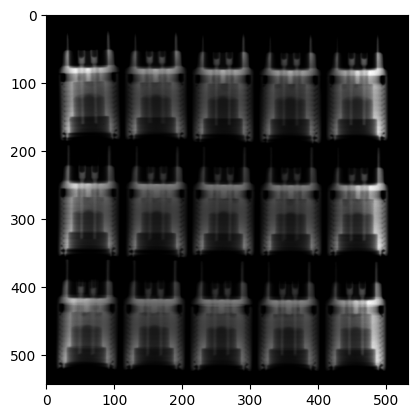

In [33]:
def homomorphic_filter(img, sigma=30, low_gain=0.5, high_gain=2.0):
    # img: uint8 grayscale
    img_log = np.log1p(img.astype(np.float32))
    # gaussian low-pass in frequency via blur
    low = cv2.GaussianBlur(img_log, (0,0), sigmaX=sigma, sigmaY=sigma)
    # high-frequency (detail) = img_log - low
    detail = img_log - low
    enhanced = low_gain * low + high_gain * detail
    out = np.expm1(enhanced)
    out = np.clip((out - out.min()) / (out.max() - out.min()) * 255, 0, 255).astype(np.uint8)
    return out

# Use after CLAHE:
# img1 = clahe(img)
# img2 = homomorphic_filter(img1, sigma=40, low_gain=0.7, high_gain=1.8)
img_clahe_homomorphic = homomorphic_filter(img, sigma=40, low_gain=0.7, high_gain=1.8)
plt.imshow(img_clahe_homomorphic, cmap='gray')
save_img('/Users/apple/Desktop/IISC/M.Tech Project/Code/Images/CLAHE_Enhancements/clahe_homomorphic.png', img_clahe_homomorphic)

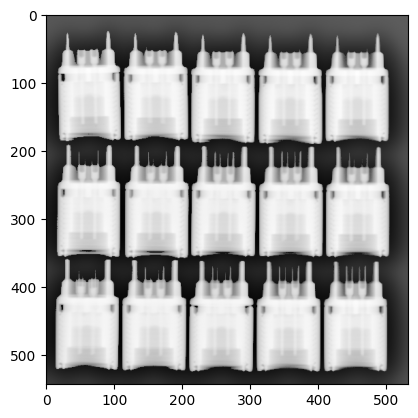

In [34]:
from scipy import ndimage as ndi

def msr_gray(img, sigmas=(15, 80, 250), weights=None):
    if weights is None:
        weights = np.ones(len(sigmas)) / len(sigmas)
    img_f = img.astype(np.float32) + 1.0
    msr = np.zeros_like(img_f)
    for s, w in zip(sigmas, weights):
        blur = ndi.gaussian_filter(img_f, sigma=s)
        msr += w * (np.log(img_f) - np.log(blur + 1e-9))
    # normalize to 0..255
    msr = msr - msr.min()
    msr = 255 * msr / (msr.max() + 1e-9)
    return msr.astype(np.uint8)
clahe_msr_gray = msr_gray(img)
plt.imshow(clahe_msr_gray, cmap='gray')
save_img('/Users/apple/Desktop/IISC/M.Tech Project/Code/Images/CLAHE_Enhancements/clahe_msr.png', clahe_msr_gray)


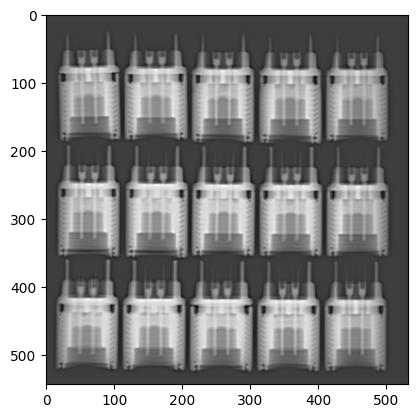

In [35]:
def clahe_then_dog(img_clahe, sigma1=1.0, sigma2=3.0):
    im = img_clahe.astype(np.float32) / 255.0
    g1 = ndi.gaussian_filter(im, sigma=sigma1)
    g2 = ndi.gaussian_filter(im, sigma=sigma2)
    dog = g1 - g2
    dog = (dog - dog.min()) / (dog.max() - dog.min() + 1e-9)
    # optionally fuse with original to highlight
    fused = 0.6 * (img_clahe.astype(np.float32)/255.0) + 0.4 * dog
    fused = np.clip(fused * 255, 0, 255).astype(np.uint8)
    return fused
img_clahe_dog = clahe_then_dog(img, sigma1=1.0, sigma2=3.0)
plt.imshow(img_clahe_dog, cmap='gray')
save_img('/Users/apple/Desktop/IISC/M.Tech Project/Code/Images/CLAHE_Enhancements/clahe_dog.png', img_clahe_dog)

This looks the most promising so far.

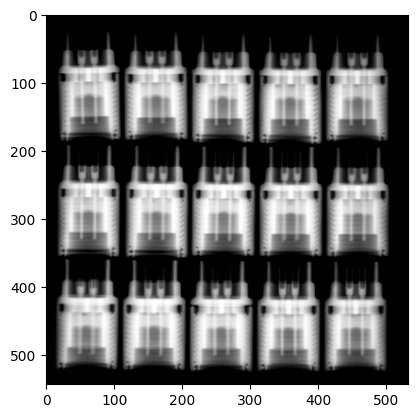

In [36]:
def multi_scale_clahe(img, clip_limits=(2.0, 2.0, 3.0), tile_sizes=((8,8),(16,16),(32,32)), weights=None):
    if weights is None:
        weights = [1.0/len(tile_sizes)] * len(tile_sizes)
    outs = []
    for clip, tile in zip(clip_limits, tile_sizes):
        clahe_obj = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
        outs.append(clahe_obj.apply(img).astype(np.float32) / 255.0)
    fused = sum(w * o for w, o in zip(weights, outs))
    fused = np.clip(fused * 255, 0, 255).astype(np.uint8)
    return fused

# Example: img_ms = multi_scale_clahe(img, clip_limits=(2.0,2.5,3.0), tile_sizes=((8,8),(16,16),(32,32)))
img_ms_clahe = multi_scale_clahe(img, clip_limits=(2.0,2.5,3.0), tile_sizes=((8,8),(16,16),(32,32)))
plt.imshow(img_ms_clahe, cmap='gray')
save_img('/Users/apple/Desktop/IISC/M.Tech Project/Code/Images/CLAHE_Enhancements/multi_scale_clahe.png', img_ms_clahe)

## Inferance 
Now, let's try to perform inferance on some pre-trained TOD models and let's see what we get. Mind you, expectations are not to indentify / locate the voids as such but to see what kind of the results we're seeing from the models. We do expect it to perform (very) poorly since we haven't performed any fine-tuning on the GTMS dataset[We don't even have a valid dataset as such, only pictures, lord knows who will perform the data annotations, most probably me :( ]

Anyways, let's start with feeding the images into the models

##### DETR

In [7]:
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image, ImageDraw
import json
import os

# Paths
dataset_dir = os.path.expanduser("/home/godwinkhalko/ISRO/Images/Clahe")
img_dir = os.path.join(dataset_dir, "")  # Adjust if images are in subfolders
prediction_dir = os.path.expanduser("/home/godwinkhalko/ISRO/Predictions_Single/DETR")
os.makedirs(prediction_dir, exist_ok=True)

# Load model and processor
model_name = "facebook/detr-resnet-50"
processor = DetrImageProcessor.from_pretrained(model_name)
model = DetrForObjectDetection.from_pretrained(model_name)

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Run inference on our custom images 
predictions = []
# Iterate through images present in the img_dir
for img_id in os.listdir(img_dir):
    if not img_id.endswith('.png'):
        continue  # Skip non-image files
    img_id = img_id.split('.')[0]  # Use filename without extension as ID
    print(f"Processing image {img_id}")
    img_path = os.path.join(img_dir, img_id + '.png')  # Assuming images are in png format
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        continue

    image = Image.open(img_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    # Post-process
    target_sizes = torch.tensor([image.size[::-1]]).to(device)
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

    # Prepare predictions, since we're feeding in our custom images without COCO IDs, we create our own IDs
    #and save the image with bounding boxes into the prediction directory
    draw = image.copy()
    for score, label, box1 in zip(results["scores"], results["labels"], results["boxes"]):
        box = box1.cpu().numpy().tolist()
        prediction = {
            "image_id": img_id,
            "category_id": int(label.cpu().numpy()),
            "bbox": [box[0], box[1], box[2]-box[0], box[3]-box[1]],  # Convert to [x, y, width, height]
            "score": float(score.cpu().numpy()),
        }
        predictions.append(prediction)
        box = box1.cpu().numpy().astype(int)
        draw1 = ImageDraw.Draw(draw)
        draw1.rectangle(((box[0], box[1]), (box[2], box[3])), outline="red", width=2)
    safe_id = "".join(c if c.isalnum() or c in "._-" else "_" for c in img_id)
    draw.save(os.path.join(prediction_dir, f"{safe_id}_pred.png"))

# Save predictions
output_json = os.path.join(prediction_dir,"predictions.json")
#Create path if it does not exists
os.makedirs(os.path.dirname(output_json), exist_ok=True)
with open(output_json, "w") as f:
    json.dump(predictions, f)
print(f"Saved {len(predictions)} predictions to {output_json}")

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Processing image clahe copy 8
Processing image clahe copy 6
Processing image clahe copy 13
Processing image clahe copy 9
Processing image clahe copy 2
Processing image clahe copy 7
Processing image clahe copy 14
Processing image clahe copy 10
Processing image clahe copy
Processing image clahe copy 12
Processing image clahe copy 11
Processing image clahe copy 3
Processing image clahe copy 15
Processing image clahe copy 4
Processing image clahe copy 5
Saved 0 predictions to /home/godwinkhalko/ISRO/Predictions_Single/DETR/predictions.json


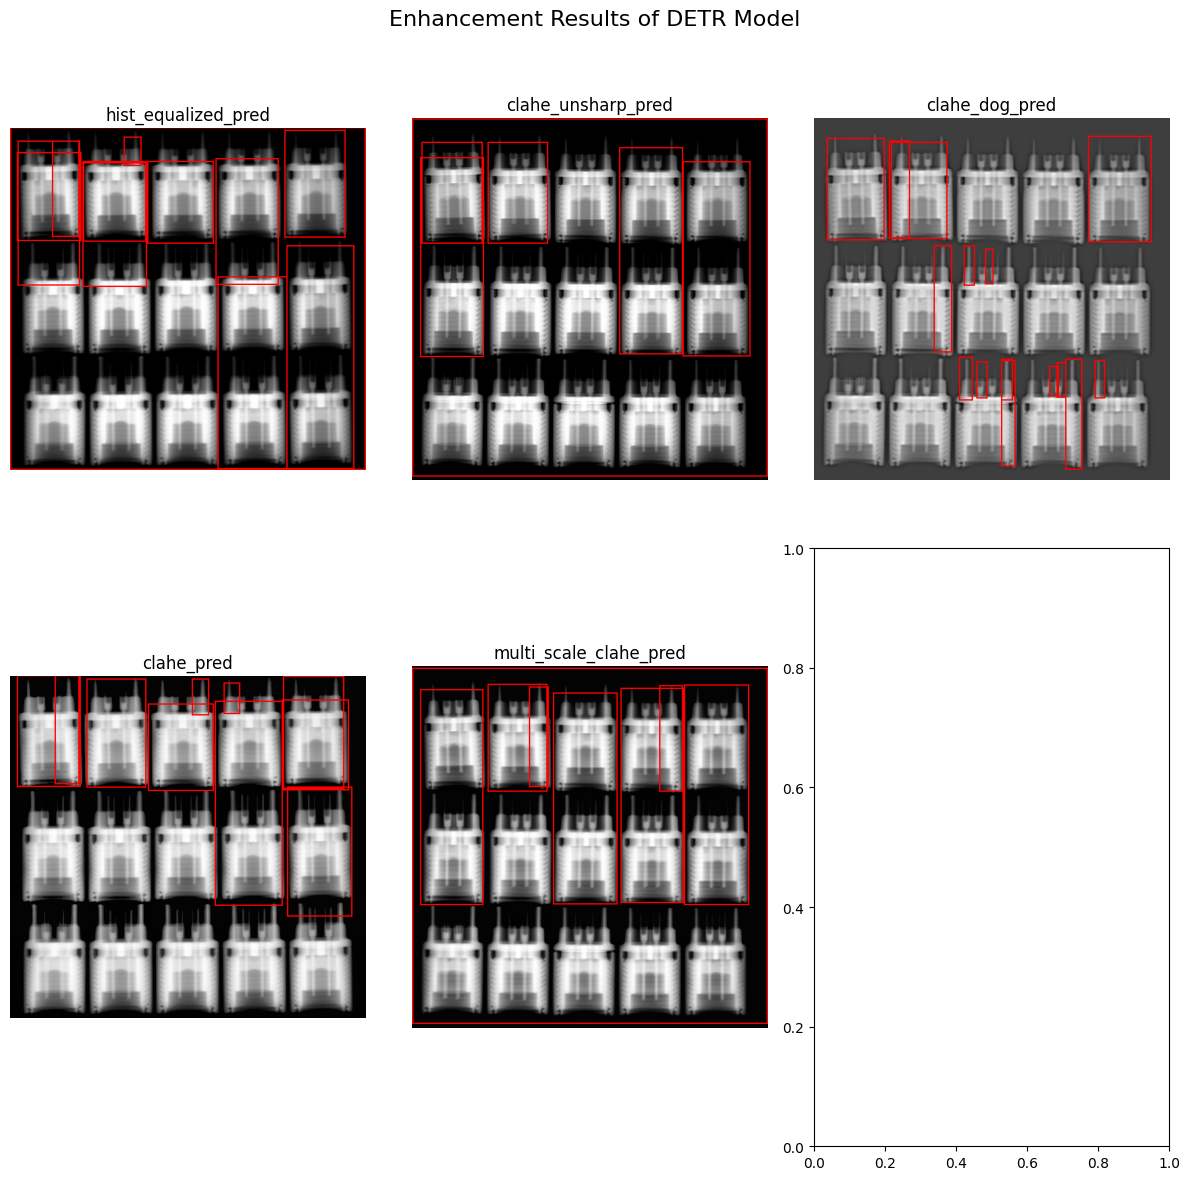

In [12]:
## Make a grid of the enhancement results for comparison from the Prediction/DETR folder
from SimpleITK import Threshold

def show_grid(titles, imgs):
    # Create a grid of images for comparison
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 12))
    for ax, title, img in zip(axes.flatten(), titles, imgs):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    ## Title of the entire figure as "Enhancement Results of DETR Model"
    fig.suptitle("Enhancement Results of DETR Model", fontsize=16)
    plt.show()
titles = []
folder_path = '/home/godwinkhalko/ISRO/Predictions/DETR'
imgs = []
for img in os.listdir(folder_path):
    if not img.endswith('.png'):
        continue
    img_path = os.path.join(folder_path, img)
    img = Image.open(img_path)
    imgs.append(img)
    #Add the title as the image filename without the .png extension
    titles.append(os.path.basename(img_path).split('.')[0])
show_grid(titles, imgs)

##### DETR-SAHI

In [8]:
import os
import json
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
from sahi.predict import get_sliced_prediction
from PIL import Image, ImageDraw
from pycocotools.coco import COCO

# Paths (adjust as needed)
dataset_dir = os.path.expanduser("/home/godwinkhalko/ISRO/Images/Clahe")
img_dir = os.path.join(dataset_dir, "")  # Adjust if images are in subfolders
prediction_dir = os.path.expanduser("/home/godwinkhalko/ISRO/Predictions_Single/DETR_SAHI")
os.makedirs(prediction_dir, exist_ok=True)

from sahi import AutoDetectionModel

# Load RT-DETR (use 'rtdetr-l.pt' for balanced speed/accuracy; 'rtdetr-x.pt' for highest accuracy)
model_path = "rtdetr-l.pt"  # Auto-downloads if not present
detection_model = AutoDetectionModel.from_pretrained(
    model_type="ultralytics",  # SAHI backend for Ultralytics
    model_path=model_path,
    confidence_threshold=0.3,  # Adjust based on your needs (0.25-0.5 common for small objects)
    device="cuda:0"  # Or "cpu"
)

# Run sliced inference and collect predictions
predictions = []
# Iterate through images present in the img_dir
for img_id in os.listdir(img_dir):
    if not img_id.endswith('.png'):
        continue  # Skip non-image files
    img_id = img_id.split('.')[0]  # Use filename without extension as ID
    print(f"Processing image {img_id}")
    img_path = os.path.join(img_dir, img_id + '.png')  # Assuming images are in png format
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        continue

    image = Image.open(img_path).convert("RGB")

    # Sliced inference with SAHI
    result = get_sliced_prediction(
        img_path,
        detection_model,
        slice_height=256,  # Smaller slices for small objects in UAVDT
        slice_width=256,
        overlap_height_ratio=0.2,
        overlap_width_ratio=0.2,
        perform_standard_pred=False  # Only sliced for better small obj detection
    )

    # Prepare predictions, since we're feeding in our custom images without COCO IDs, we create our own IDs
    #and save the image with bounding boxes into the prediction directory
    draw = image.copy()
    for pred in result.object_prediction_list:
        box = pred.bbox.to_xyxy()
        draw1 = ImageDraw.Draw(draw)
        draw1.rectangle(((box[0], box[1]), (box[2], box[3])), outline="blue", width=2)
    safe_id = "".join(c if c.isalnum() or c in "._-" else "_" for c in img_id)
    draw.save(os.path.join(prediction_dir, f"{safe_id}_pred.png"))

# Save predictions
output_json = os.path.join(prediction_dir,"predictions.json")
#Create path if it does not exists
os.makedirs(os.path.dirname(output_json), exist_ok=True)
with open(output_json, "w") as f:
    json.dump(predictions, f)
print(f"Saved {len(predictions)} predictions to {output_json}")

Processing image clahe copy 8
Performing prediction on 1 slices.
Processing image clahe copy 6
Performing prediction on 1 slices.
Processing image clahe copy 13
Performing prediction on 1 slices.
Processing image clahe copy 9
Performing prediction on 1 slices.
Processing image clahe copy 2
Performing prediction on 1 slices.
Processing image clahe copy 7
Performing prediction on 1 slices.
Processing image clahe copy 14
Performing prediction on 1 slices.
Processing image clahe copy 10
Performing prediction on 1 slices.
Processing image clahe copy
Performing prediction on 1 slices.
Processing image clahe copy 12
Performing prediction on 1 slices.
Processing image clahe copy 11
Performing prediction on 1 slices.
Processing image clahe copy 3
Performing prediction on 1 slices.
Processing image clahe copy 15
Performing prediction on 1 slices.
Processing image clahe copy 4
Performing prediction on 1 slices.
Processing image clahe copy 5
Performing prediction on 1 slices.
Saved 0 predictions t

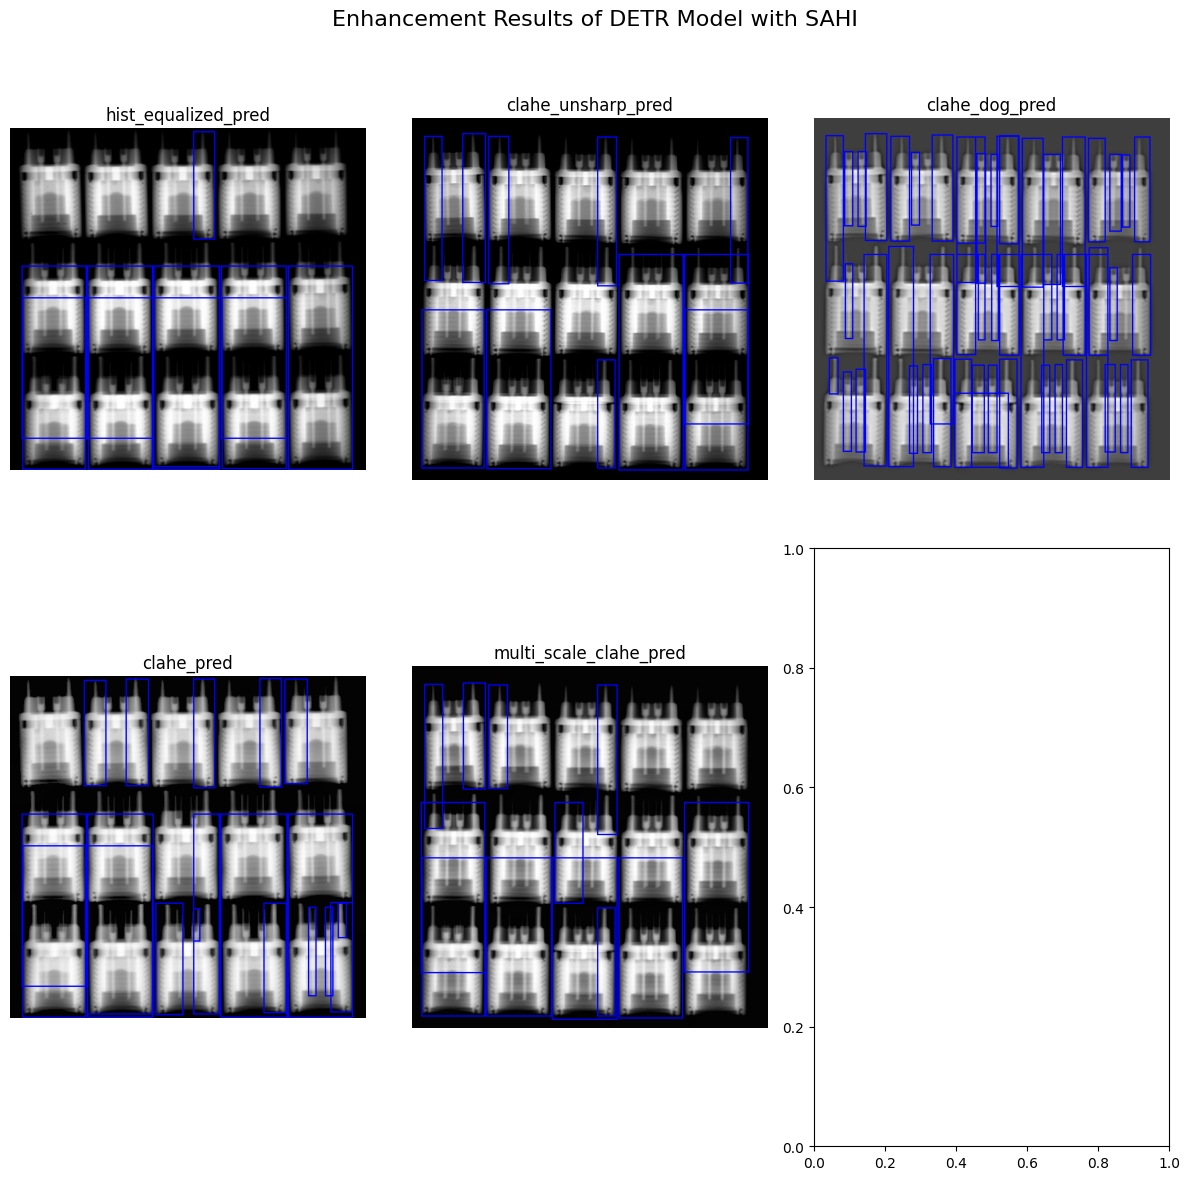

In [13]:
## Make a grid of the enhancement results for comparison from the Prediction/DETR folder
from SimpleITK import Threshold

def show_grid(titles, imgs):
    # Create a grid of images for comparison
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 12))
    for ax, title, img in zip(axes.flatten(), titles, imgs):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    ## Title of the entire figure as "Enhancement Results of DETR Model"
    fig.suptitle("Enhancement Results of DETR Model with SAHI", fontsize=16)
    plt.show()
titles = []
folder_path = '/home/godwinkhalko/ISRO/Predictions/DETR_SAHI'
imgs = []
for img in os.listdir(folder_path):
    if not img.endswith('.png'):
        continue
    img_path = os.path.join(folder_path, img)
    img = Image.open(img_path)
    imgs.append(img)
    #Add the title as the image filename without the .png extension
    titles.append(os.path.basename(img_path).split('.')[0])
show_grid(titles, imgs)

#### D-Fine Model with SAHI

We'll try some more models to perform inferance and see what kind of results we're able to achieve

In [2]:
import os
import torch
from transformers import DFineForObjectDetection
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from PIL import Image, ImageDraw

# Paths (adjust as needed)
dataset_dir = os.path.expanduser("/home/godwinkhalko/ISRO/Images/Images_to_use")
img_dir = os.path.join(dataset_dir, "")  # Adjust if images are in subfolders
prediction_dir = os.path.expanduser("/home/godwinkhalko/ISRO/Predictions/D_FINE_SAHI")
os.makedirs(prediction_dir, exist_ok=True)

# Load D-FINE model via Hugging Face Transformers + SAHI integration
# Recommended variants (higher = better accuracy, slower):
# - "ustc-community/dfine_n_coco" (Nano, fastest)
# - "ustc-community/dfine_m_coco" (Medium)
# - "ustc-community/dfine_l_coco" (Large)
# - "ustc-community/dfine_x_coco" (X, highest accuracy, ~55.8 AP on COCO, excellent for small objects)
model_checkpoint = "ustc-community/dfine_x_coco"  # Change to smaller variant if needed for speed

detection_model = AutoDetectionModel.from_pretrained(
    model_type="huggingface",
    model_path=model_checkpoint,
    confidence_threshold=0.3,  # Adjust (0.2-0.4 common for small objects)
    device="cuda:0" if torch.cuda.is_available() else "cpu"
)

# Run sliced inference on all images
for filename in os.listdir(img_dir):
    if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue
    
    img_id = os.path.splitext(filename)[0]  # Filename without extension as ID
    print(f"Processing image {img_id}")
    
    img_path = os.path.join(img_dir, filename)
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        continue
    
    image = Image.open(img_path).convert("RGB")
    
    # Sliced inference with SAHI (great for small objects in high-res images like UAV/drone)
    result = get_sliced_prediction(
        image,  # Can pass PIL Image or path
        detection_model,
        slice_height=384,      # Larger slices than RT-DETR for better context (D-FINE handles large inputs well)
        slice_width=384,
        overlap_height_ratio=0.2,
        overlap_width_ratio=0.2,
        perform_standard_pred=False  # Only sliced for maximum small object recall
    )
    
    # Draw bounding boxes and save visualized image
    draw = image.copy()
    draw1 = ImageDraw.Draw(draw)
    
    for pred in result.object_prediction_list:
        box = pred.bbox.to_xyxy()  # [xmin, ymin, xmax, ymax]
        draw1.rectangle(((box[0], box[1]), (box[2], box[3])), outline="blue", width=3)
        label = f"{pred.category.name}: {pred.score.value:.2f}"
        draw1.text((box[0], box[1] - 10), label, fill="blue")
    
    safe_id = "".join(c if c.isalnum() or c in "._-" else "_" for c in img_id)
    draw.save(os.path.join(prediction_dir, f"{safe_id}_pred.png"))

print("Inference complete! Visualized predictions saved to:", prediction_dir)

ImportError: cannot import name 'DFineForObjectDetection' from 'transformers' (/home/godwinkhalko/python-envs/dlcv-project/lib/python3.8/site-packages/transformers/__init__.py)

In [2]:
import transformers
import transformers
print(transformers.__file__)
print(transformers.__version__)

/home/godwinkhalko/python-envs/dlcv-project/lib/python3.8/site-packages/transformers/__init__.py
4.46.3
